<a href="https://colab.research.google.com/github/Solo7602/MADPA/blob/main/mosh_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Load Saving BERT embedding...
              precision    recall  f1-score   support

           0       0.56      0.83      0.67     11447
           1       0.44      0.23      0.30      7764
           2       0.51      0.38      0.43      6067

    accuracy                           0.53     25278
   macro avg       0.50      0.48      0.47     25278
weighted avg       0.51      0.53      0.50     25278

Cross-valid F1-score: 0.4638 ± 0.0003


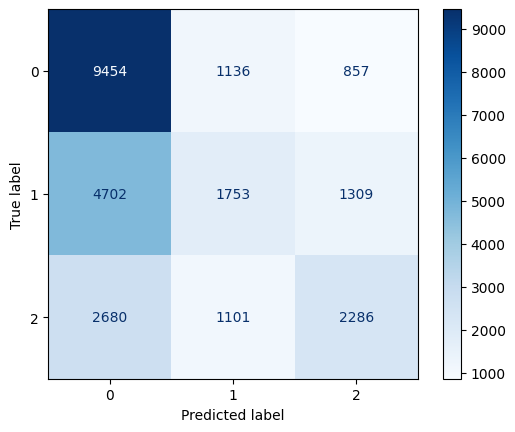

In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # избегаем конфликта с TensorFlow

import pandas as pd
import json
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tqdm import tqdm

# Загружаем данные
data = pd.read_csv('all_dataset_processed.csv')


numeric_features = ['Spell_Errors', 'Slang_Count', 'Emoji_Count', 'Punctuation_Count', 'Word_Count', 'Avg_Word_Length', 'Comment_Length', 'Ends_With_Punct', 'Has_Slang', 'Has_Spell_Errors']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numeric_features]).astype(int)

# BERT эмбеддинги
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

bert_file = 'bert_embeddings.npy'

if os.path.exists(bert_file):
    print("Load Saving BERT embedding...")
    bert_features = np.load(bert_file)
else:
    print("Generate BERT embedding...")
    bert_embeddings = []
    for comment in tqdm(data['Comment_processed'], desc="BERT embedding"):
        try:
            emb = get_bert_embedding(comment)
        except Exception:
            emb = np.zeros(768)
        bert_embeddings.append(emb)

    bert_features = np.vstack(bert_embeddings)
    np.save(bert_file, bert_features)  # Сохраняем в файл


# Объединение признаков
X = np.hstack([bert_features, scaled_features])

y = data['Age_Group'].values

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Обучение XGBoost
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    n_estimators=300,
    eval_metric="mlogloss",
    random_state=42
)

xgb_clf.fit(X_train, y_train)

# Предсказание и оценка
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Кросс-валидация
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_clf, X, y, cv=cv, scoring='f1_macro')

print(f'Cross-valid F1-score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# # Подбор гиперпараметров с помощью GridSearchCV
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [150, 200, 250],
# }

# grid_search = GridSearchCV(xgb_clf, param_grid, scoring='f1_macro', cv=cv)
# grid_search.fit(X_train, y_train)

# print(f'Best parms: {grid_search.best_params_}')
# print(f'Best F1-score: {grid_search.best_score_:.4f}')

# Анализ ошибок
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')